## Plot mutation prediction results

In this notebook, we'll compare the results of our mutation prediction experiments for expression and methylation data only (see `README.md` for more details). The files analyzed in this notebook are generated by the `run_mutation_prediction.py` script.

Notebook parameters:
* SIG_ALPHA (float): significance cutoff (after FDR correction)

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from adjustText import adjust_text

import mpmp.config as cfg
import mpmp.utilities.analysis_utilities as au

In [2]:
# set results directory
results_dir = Path(cfg.results_dirs['mutation'],
                   'methylation_results',
                   'gene').resolve()

# set significance cutoff after FDR correction
SIG_ALPHA = 0.001

# if True, save figures to ./images directory
SAVE_FIGS = True

In [3]:
# load raw data
results_df = au.load_stratified_prediction_results(results_dir, 'gene')

# here we want to use compressed data for methylation datasets (27k and 450k)
# the results in 02_classify_compressed/compressed_vs_raw_results.ipynb show that
# performance is equal or slightly better for PCA compressed methylation data,
# and it's much easier/faster to fit models on
results_df = results_df[results_df.training_data.isin(['expression'])]

print(results_df.shape)
print(results_df.seed.unique())
print(results_df.training_data.unique())
results_df.head()

(4032, 9)
[42  1]
['expression']


,auroc,aupr,identifier,training_data,signal,seed,data_type,fold,experiment
0,0.99936,0.99278,MAP3K1,expression,signal,42,train,0,gene
1,0.59870,0.14903,MAP3K1,expression,signal,42,test,0,gene
2,0.66496,0.20677,MAP3K1,expression,signal,42,cv,0,gene
3,0.99468,0.91588,MAP3K1,expression,signal,42,train,1,gene
4,0.75569,0.40224,MAP3K1,expression,signal,42,test,1,gene


In [4]:
# load compressed data for me_27k and me_450k
compressed_results_df = au.load_compressed_prediction_results(results_dir, 'gene',
                                                              old_filenames=True)
compressed_results_df = compressed_results_df[(compressed_results_df.training_data.isin(['me_27k', 'me_450k'])) &
                                              (compressed_results_df.n_dims == 5000)]
print(compressed_results_df.seed.unique())
print(compressed_results_df.training_data.unique())
print(compressed_results_df.n_dims.unique())
print(compressed_results_df.shape)
compressed_results_df.head()

[ 1 42]
['me_450k' 'me_27k']
[5000]
(8064, 10)


,auroc,aupr,identifier,training_data,signal,seed,data_type,fold,n_dims,experiment
0,1.00000,1.00000,MAP3K1,me_450k,signal,1,train,0,5000,gene
1,0.62605,0.21212,MAP3K1,me_450k,signal,1,test,0,5000,gene
2,0.64376,0.25047,MAP3K1,me_450k,signal,1,cv,0,5000,gene
3,0.99839,0.97592,MAP3K1,me_450k,signal,1,train,1,5000,gene
4,0.55888,0.22643,MAP3K1,me_450k,signal,1,test,1,5000,gene


In [5]:
results_df['n_dims'] = 'raw'
results_df = pd.concat((results_df, compressed_results_df))
print(results_df.seed.unique())
print(results_df.training_data.unique())
print(results_df.n_dims.unique())
print(results_df.shape)
training_data_map = {
    'expression': 'gene expression',
    'me_27k': '27k methylation',
    'me_450k': '450k methylation',
}
results_df.training_data.replace(to_replace=training_data_map, inplace=True)
results_df.head()

[42  1]
['expression' 'me_450k' 'me_27k']
['raw' 5000]
(12096, 10)


,auroc,aupr,identifier,training_data,signal,seed,data_type,fold,experiment,n_dims
0,0.99936,0.99278,MAP3K1,gene expression,signal,42,train,0,gene,raw
1,0.59870,0.14903,MAP3K1,gene expression,signal,42,test,0,gene,raw
2,0.66496,0.20677,MAP3K1,gene expression,signal,42,cv,0,gene,raw
3,0.99468,0.91588,MAP3K1,gene expression,signal,42,train,1,gene,raw
4,0.75569,0.40224,MAP3K1,gene expression,signal,42,test,1,gene,raw


In [6]:
all_results_df = pd.DataFrame()
for training_data in results_df.training_data.unique():
    data_df = results_df[results_df.training_data == training_data].copy()
    data_df.sort_values(by=['seed', 'fold'], inplace=True)
    data_results_df = au.compare_results(data_df,
                                         identifier='identifier',
                                         metric='aupr',
                                         correction=True,
                                         correction_method='fdr_bh',
                                         correction_alpha=SIG_ALPHA,
                                         verbose=True)
    data_results_df['training_data'] = training_data
    data_results_df.rename(columns={'identifier': 'gene'}, inplace=True)
    all_results_df = pd.concat((all_results_df, data_results_df))
    
# now filter out genes that don't have comparisons for all data types
data_type_counts = all_results_df.groupby('gene').count().training_data
valid_genes = data_type_counts[data_type_counts == len(results_df.training_data.unique())].index
all_results_df = all_results_df[
    all_results_df.gene.isin(valid_genes)
]
all_results_df.sort_values(by='p_value').head(10)

,gene,delta_mean,p_value,corr_pval,reject_null,training_data
81,TP53,0.405700,8.617891e-12,7.239029e-10,True,gene expression
62,NRAS,0.554801,5.320457e-11,2.712944e-09,True,450k methylation
81,TP53,0.404420,6.459390e-11,2.712944e-09,True,450k methylation
13,BRAF,0.544941,1.698771e-10,5.093371e-09,True,gene expression
69,PTEN,0.580670,2.034746e-10,5.093371e-09,True,gene expression
81,TP53,0.397715,2.202870e-10,1.850411e-08,True,27k methylation
51,KRAS,0.499401,2.425415e-10,5.093371e-09,True,gene expression
13,BRAF,0.505500,5.660591e-10,1.584965e-08,True,450k methylation
69,PTEN,0.459739,5.809448e-10,2.439968e-08,True,27k methylation
28,FBXW7,0.366896,2.070250e-09,3.478020e-08,True,gene expression


gene expression: 42/84
27k methylation: 42/84
450k methylation: 39/84


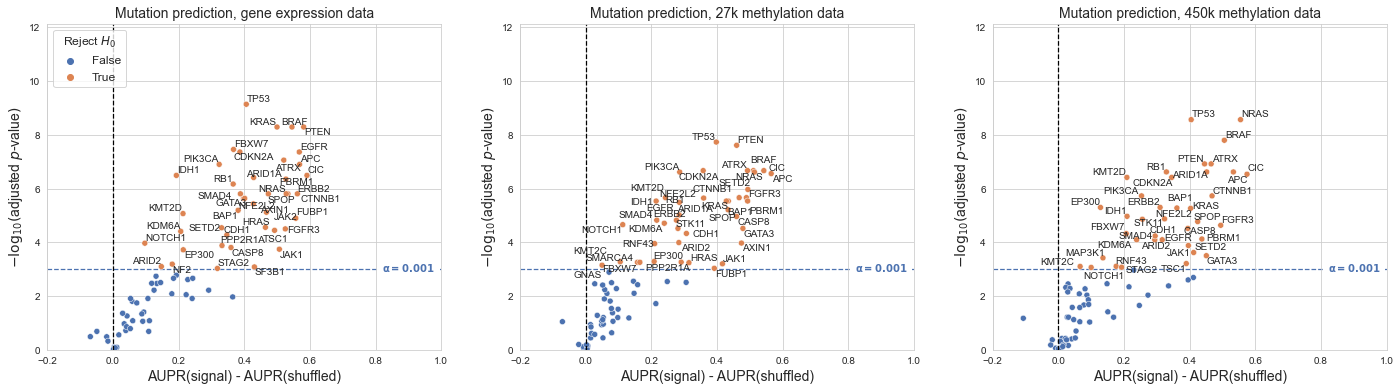

In [7]:
all_results_df['nlog10_p'] = -np.log10(all_results_df.corr_pval)

sns.set({'figure.figsize': (24, 6)})
sns.set_style('whitegrid')
fig, axarr = plt.subplots(1, 3)

# all plots should have the same axes for a fair comparison
xlim = (-0.2, 1.0)
y_max = all_results_df.nlog10_p.max()
ylim = (0, y_max+3)

# function to add gene labels to points
def label_points(x, y, gene, ax):
    text_labels = []
    a = pd.DataFrame({'x': x, 'y': y, 'gene': gene})
    for i, point in a.iterrows():
        if point['y'] > -np.log10(SIG_ALPHA):
            text_labels.append(
                ax.text(point['x'], point['y'], str(point['gene']))
            )
    return text_labels

# plot mutation prediction from expression, in a volcano-like plot
for ix, training_data in enumerate(['gene expression', '27k methylation', '450k methylation']):
    ax = axarr[ix]
    data_results_df = all_results_df[all_results_df.training_data == training_data]
    sns.scatterplot(data=data_results_df, x='delta_mean', y='nlog10_p', hue='reject_null',
                    hue_order=[False, True], ax=ax,
                    legend=(ix == 0))
    # add vertical line at 0
    ax.axvline(x=0, linestyle='--', linewidth=1.25, color='black')
    # add horizontal line at statistical significance threshold
    l = ax.axhline(y=-np.log10(SIG_ALPHA), linestyle='--', linewidth=1.25, zorder=-1)
    # label horizontal line with significance threshold
    # (matplotlib makes this fairly difficult, sadly)
    ax.text(0.9, -np.log10(SIG_ALPHA)+0.05,
            r'$\mathbf{{\alpha = {}}}$'.format(SIG_ALPHA),
            va='center', ha='center', color=l.get_color(),
            backgroundcolor=ax.get_facecolor(),
            zorder=0)
    ax.set_xlabel('AUPR(signal) - AUPR(shuffled)', size=14)
    ax.set_ylabel(r'$-\log_{10}($adjusted $p$-value$)$', size=14)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    if ix == 0:
        ax.legend(title=r'Reject $H_0$', loc='upper left',
                  fontsize=12, title_fontsize=12)
    ax.set_title(r'Mutation prediction, {} data'.format(training_data), size=14)

    # label genes and adjust text to not overlap
    # automatic alignment isn't perfect, can align by hand in inkscape if necessary
    text_labels = label_points(data_results_df['delta_mean'],
                               data_results_df['nlog10_p'],
                               data_results_df.gene,
                               ax)
    
    adjust_text(text_labels,
                ax=ax, 
                expand_text=(1., 1.),
                lim=5)
    
    print('{}: {}/{}'.format(
        training_data,
        np.count_nonzero(data_results_df.reject_null),
        data_results_df.shape[0]
    ))
    
if SAVE_FIGS:
    images_dir = Path(cfg.images_dirs['mutation'])
    images_dir.mkdir(exist_ok=True)
    plt.savefig(images_dir / 'methylation_vs_shuffled.svg', bbox_inches='tight')
    plt.savefig(images_dir / 'methylation_vs_shuffled.png',
                dpi=300, bbox_inches='tight')

27k methylation: 6/84
450k methylation: 2/84


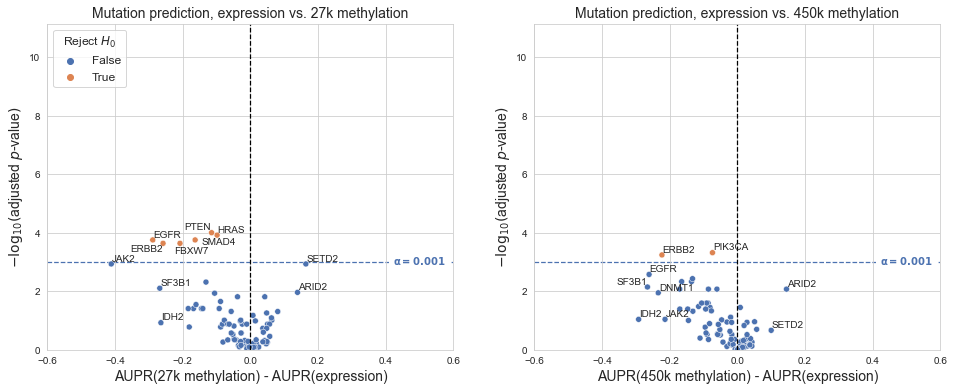

In [8]:
# compare expression against all other data modalities
# could do all vs. all, but that would give us lots of plots

# function to add gene labels to points
def label_points(x, y, gene, ax):
    text_labels = []
    a = pd.DataFrame({'x': x, 'y': y, 'gene': gene})
    for i, point in a.iterrows():
        if (point['y'] > -np.log10(0.001)) or (point['x'] > 0.1) or (abs(point['x']) > 0.2):
            text_labels.append(
                ax.text(point['x'], point['y'], str(point['gene']))
            )
    return text_labels

sns.set({'figure.figsize': (16, 6)})
sns.set_style('whitegrid')
fig, axarr = plt.subplots(1, 2)

# all plots should have the same axes for a fair comparison
xlim = (-0.6, 0.6)
# TODO: maybe adjust these afterward?
y_max = all_results_df.nlog10_p.max()
ylim = (0, y_max+2)

data_types = sorted([dt for dt in all_results_df.training_data.unique() if dt != 'gene expression'])
exp_results_df = results_df[results_df.training_data == 'gene expression'].copy()
exp_results_df.sort_values(by=['seed', 'fold'], inplace=True)

for ix, training_data in enumerate(data_types):
    ax = axarr[ix]
    data_results_df = results_df[results_df.training_data == training_data].copy()
    data_results_df.sort_values(by=['seed', 'fold'], inplace=True)
    compare_results_df = au.compare_results(exp_results_df,
                                            condition_2_df=data_results_df,
                                            identifier='identifier',
                                            metric='aupr',
                                            correction=True,
                                            correction_method='fdr_bh',
                                            correction_alpha=SIG_ALPHA,
                                            verbose=True)
    compare_results_df.rename(columns={'identifier': 'gene'}, inplace=True)
    compare_results_df['nlog10_p'] = -np.log10(compare_results_df.corr_pval)
    sns.scatterplot(data=compare_results_df, x='delta_mean', y='nlog10_p', hue='reject_null',
                    hue_order=[False, True], ax=ax, legend=(ix == 0))

    # add vertical line at 0
    ax.axvline(x=0, linestyle='--', linewidth=1.25, color='black')
    # add horizontal line at statistical significance threshold
    l = ax.axhline(y=-np.log10(SIG_ALPHA), linestyle='--', linewidth=1.25, zorder=-1)
    # label horizontal line with significance threshold
    # (matplotlib makes this fairly difficult, sadly)
    ax.text(0.5, -np.log10(SIG_ALPHA)+0.05,
            r'$\mathbf{{\alpha = {}}}$'.format(SIG_ALPHA),
            va='center', ha='center', color=l.get_color(),
            backgroundcolor=ax.get_facecolor(),
            zorder=0)
    ax.set_xlabel('AUPR({}) - AUPR(expression)'.format(training_data), size=14)
    ax.set_ylabel(r'$-\log_{10}($adjusted $p$-value$)$', size=14)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    if ix == 0:
        ax.legend(title=r'Reject $H_0$', loc='upper left',
                  fontsize=12, title_fontsize=12)
    ax.set_title(r'Mutation prediction, expression vs. {}'.format(training_data), size=14)

    text_labels = label_points(compare_results_df['delta_mean'],
                               compare_results_df['nlog10_p'],
                               compare_results_df.gene,
                               ax)
    adjust_text(text_labels,
                ax=ax,
                expand_text=(1., 1.),
                lim=5)
    
    print('{}: {}/{}'.format(training_data,
                             np.count_nonzero(compare_results_df.reject_null),
                             compare_results_df.shape[0]))
    
if SAVE_FIGS:
    images_dir = Path(cfg.images_dirs['mutation'])
    images_dir.mkdir(exist_ok=True)
    plt.savefig(images_dir / 'methylation_comparison.svg', bbox_inches='tight')
    plt.savefig(images_dir / 'methylation_comparison.png',
                dpi=300, bbox_inches='tight')

(48,)
['APC' 'ARID1A' 'ARID2' 'ATRX' 'AXIN1' 'BAP1' 'BRAF' 'CASP8' 'CDH1'
 'CDKN2A' 'CIC' 'CTNNB1' 'EGFR' 'EP300' 'ERBB2' 'FBXW7' 'FGFR3' 'FUBP1'
 'GATA3' 'HRAS' 'IDH1' 'JAK1' 'JAK2' 'KDM6A' 'KMT2D' 'KRAS' 'NF2' 'NFE2L2'
 'NOTCH1' 'NRAS' 'PBRM1' 'PIK3CA' 'PPP2R1A' 'PTEN' 'RB1' 'SETD2' 'SF3B1'
 'SMAD4' 'SPOP' 'STAG2' 'TP53' 'TSC1' 'KMT2C' 'MAP3K1' 'RNF43' 'STK11'
 'GNAS' 'SMARCA4']


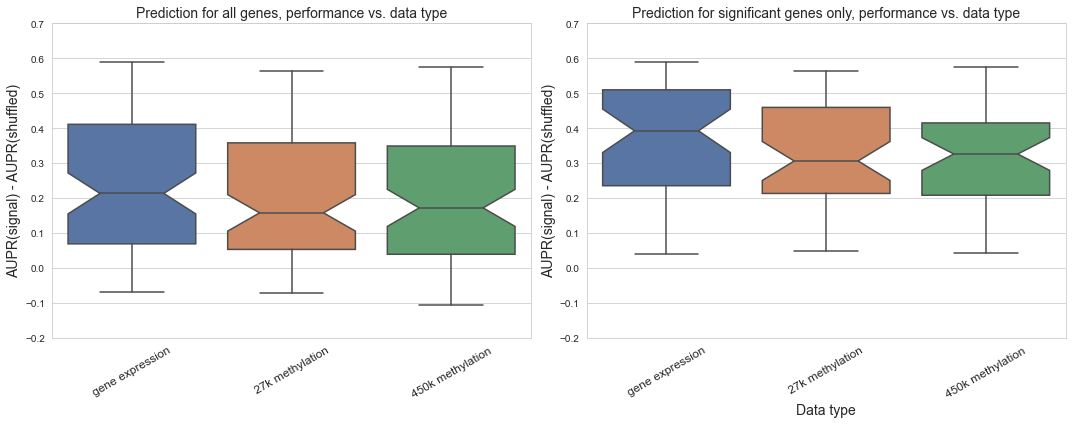

In [10]:
sns.set({'figure.figsize': (15, 6)})
sns.set_style('whitegrid')
fig, axarr = plt.subplots(1, 2)

# plot mean performance over all genes in Vogelstein dataset
ax = axarr[0]
sns.boxplot(data=all_results_df, x='training_data', y='delta_mean', notch=True,
            ax=ax, order=list(training_data_map.values()))
ax.set_title('Prediction for all genes, performance vs. data type', size=14)
ax.set_xlabel('')
ax.set_ylabel('AUPR(signal) - AUPR(shuffled)', size=14)
ax.set_ylim(-0.2, 0.7)
for tick in ax.get_xticklabels():
    tick.set_fontsize(12)
    tick.set_rotation(30)

# plot mean performance for genes that are significant for at least one data type
ax = axarr[1]
gene_list = all_results_df[all_results_df.reject_null == True].gene.unique()
print(gene_list.shape)
print(gene_list)
sns.boxplot(data=all_results_df[all_results_df.gene.isin(gene_list)],
            x='training_data', y='delta_mean', notch=True, ax=ax,
            order=list(training_data_map.values()))
ax.set_title('Prediction for significant genes only, performance vs. data type', size=14)
ax.set_xlabel('Data type', size=14)
ax.set_ylabel('AUPR(signal) - AUPR(shuffled)', size=14)
ax.set_ylim(-0.2, 0.7)
for tick in ax.get_xticklabels():
    tick.set_fontsize(12)
    tick.set_rotation(30)
    
plt.tight_layout()

if SAVE_FIGS:
    images_dir = Path(cfg.images_dirs['mutation'])
    images_dir.mkdir(exist_ok=True)
    plt.savefig(images_dir / 'methylation_best_boxes.svg', bbox_inches='tight')
    plt.savefig(images_dir / 'methylation_best_boxes.png',
                dpi=300, bbox_inches='tight')